In [1]:
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import pytorch_lightning as pl
from torch.optim.lr_scheduler import MultiStepLR

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
# import warnings
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
pd.set_option('display.max_columns', None)
# warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:_.2f}'.format

https://www.kaggle.com/datasets/marcbuji/loan-default-prediction?datasetId=2410810&sortBy=dateRun&tab=profile

In [3]:
raw_data = pd.read_csv('./data/Data_train.csv', index_col=0)
raw_data.head(10)

,Asst_Reg,GGGrade,Experience,Validation,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Designation,Debt_to_Income,Postal_Code,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,File_Status,State,Account_Open,Total_Unpaid_CL,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
95074,421802,II,>10yrs,Vfied,633_600.00,MORTGAGE,0,0,GLENDALE NISSAN,12.55,91_300.00,42_023.25,0,15.39,88.92,3,607_161.90,0.00,19,fully paid,California,17,58_598.00,3 years,31_216.05,debt consolidation,I,0.00,0
134131,3964312,IV,7yrs,Source Verified,85_483.20,RENT,0,0,Business Teacher,9.00,27_400.00,38_133.00,0,9.94,102.86,0,269_234.06,0.00,30,whole,NC,15,18_924.00,5 years,11_660.49,debt consolidation,I,0.00,0
92602,4247560,III,<1yr,Source Verified,79_200.00,RENT,0,0,driver,24.91,32_800.00,17_100.00,0,22.35,60.37,0,22_476.53,0.00,25,whole,Florida,7,15_604.00,5 years,5_637.87,major purchase,I,0.00,0
22591,197179,III,<1yr,Vfied,61_600.00,RENT,0,0,AvePoint,16.58,7_000.00,5_130.00,0,10.36,116.27,1,15_242.09,0.00,22,fully paid,NewJersey,9,22_410.00,3 years,15_607.17,major purchase,I,0.00,1
125060,4646684,V,2yrs,Source Verified,68_053.92,RENT,0,0,Lead Tester,40.05,70_800.00,19_665.00,0,13.68,127.28,1,65_433.94,0.00,32,fully paid,LA,10,36_022.00,5 years,27_472.86,debt consolidation,I,0.00,0
21803,1771402,II,1yrs,Source Verified,219_648.00,MORTGAGE,4,0,Financial Controller,26.43,77_000.00,34_200.00,0,15.12,115.93,2,60_089.94,0.00,19,whole,TX,11,27_556.00,3 years,19_134.90,debt consolidation,I,0.00,0
141442,6308843,III,>10yrs,Source Verified,88_000.00,RENT,0,0,Chef,19.15,92_100.00,34_200.00,0,23.49,92.71,1,29_052.99,0.00,24,fully paid,California,10,53_618.00,3 years,29_748.87,debt consolidation,I,0.00,0
94448,1468916,III,4yrs,Source Verified,NaN,RENT,2,0,General manager,48.30,6_000.00,13_551.75,0,20.77,23.74,0,60_312.05,0.00,21,fully paid,CT,26,123_338.00,3 years,17_496.72,debt consolidation,I,0.00,0
109853,7067902,VII,<1yr,Vfied,NaN,RENT,0,0,laborer,26.49,92_500.00,25_692.75,0,23.09,1.89,0,44_525.54,0.00,43,whole,California,6,19_256.00,5 years,225.72,other,I,0.00,0


# 1. Исследование датасета (Data Exploration)

## I. Описание полей

**ID** - Уникальный идентификатор держателя кредитной карты <br>
**Asst_Reg** - Совокупная стоимость всех активов зарегестрированных за заёмщиком <br>
_**GGGrade**: Оценка группы выдачи кредита <br>
**Experience** - Общий стаж работы заемщика в годах <br>
**Validation** - Статус проверки заемщика <br>
**Yearly Income** - Общий годовой доход заемщика <br>
**Home Status** - Статус проживания заемщика <br>
**Unpaid 2 years** - Количество раз, когда заемщик допустил просрочку в течение последних двух лет <br>
**Already Defaulted** - Количество других кредитов, по которым заемщик допустил просрочку <br>
**Designation** - Должность заемщика <br>
**Debt to Income** - Соотношение долга к доходу <br>
**Postal Code** - Почтовый индекс заемщика <br>
**Lend Amount** - Общая сумма кредита, выданная заемщику <br>
**Deprecatory Records** - Запись, которая может рассматриваться кредиторами как негативная, так как она указывает на риск и ухудшает возможность получения кредита или других услуг <br>
**Interest Charged** - Процентная ставка по общей сумме кредита <br>
_**Usage Rate** -  Обработочные сборы на сумму кредита <br>
_**Inquiries** - Запросы за последние 6 месяцев <br>
**Present Balance** - Текущий баланс на счету заемщика <br>
**Gross Collection** - Общая сумма, подлежащая выплате в рамках урегулирования или судебного решения по искам, исключая любые расходы <br>
**Sub GGGrade** - Оценка подгруппы группы выдачи кредита <br>
**File Status** - Статус заявки на кредит <br>
**State**: Штат, к которому принадлежит заемщик <br>
**Account Open** - Общее количество открытых счетов на имя заемщика <br>
**Total Unpaid CL** - Неоплаченные задолженности по всем другим кредитам <br>
**Duration** - Срок, на который выдан кредит заемщику <br>
**Unpaid Amount** - Неоплаченный баланс по кредитной карте <br>
**Reason** - Причина подачи заявки на кредит <br>
**Claim Type** - Тип заявки заемщика среди всех типов заявок. (I - Индивидуальный счет, J - Совместный счет) <br>
**Due Fee** - Штрафные санкции за задержку выплаты по кредиту <br>
**Default** - Целевая переменная - наличие/отсутствие дефолта (1 - наличие/ 0-отсутствие) <br>

### II. Описательная характеристика датасета

In [4]:
raw_data.shape

(87500, 29)

##### Полная описательная статистика по датасету

In [5]:
raw_data.describe()#.applymap(lambda x: f'{x:_.2f}')

,Asst_Reg,Yearly_Income,Unpaid_2_years,Already_Defaulted,Debt_to_Income,Postal_Code,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,Account_Open,Total_Unpaid_CL,Unpaid_Amount,Due_Fee,Default
count,87_500.00,81_925.00,87_500.00,87_500.00,84_011.00,86_111.00,87_500.00,87_500.00,87_500.00,87_500.00,87_500.00,87_500.00,87_500.00,87_500.00,87_500.00,83_314.00,82_648.00,87_500.00,87_500.00
mean,3_798_914.12,134_859.63,0.33,0.01,30.94,51_155.39,25_920.54,0.20,16.52,95.52,0.67,236_389.46,39.46,22.02,12.78,53_268.64,29_556.49,0.32,0.19
std,2_289_038.08,98_824.73,0.88,0.08,14.08,31_211.23,14_433.84,0.65,4.90,40.55,0.96,255_056.78,391.92,6.45,5.37,53_255.51,37_456.25,3.55,0.39
min,24_847.00,8_800.00,0.00,0.00,0.00,1_000.00,1_710.00,0.00,8.00,0.00,0.00,0.00,0.00,11.00,2.00,332.00,0.00,0.00,0.00
25%,1_483_874.25,83_246.59,0.00,0.00,20.43,22_900.00,15_048.00,0.00,12.31,66.05,0.00,51_734.93,0.00,17.00,9.00,23_240.00,11_446.74,0.00,0.00
50%,4_132_010.50,114_400.00,0.00,0.00,30.14,47_700.00,23_940.00,0.00,16.49,97.01,0.00,138_806.23,0.00,21.00,12.00,39_674.00,20_892.78,0.00,0.00
75%,5_952_908.75,160_160.00,0.00,0.00,40.91,80_200.00,34_200.00,0.00,20.77,126.59,1.00,353_475.54,0.00,26.00,16.00,66_400.00,36_449.08,0.00,0.00
max,7_351_847.00,8_264_030.72,18.00,6.00,639.29,99_900.00,59_850.00,86.00,25.00,1_534.76,8.00,5_629_234.33,26_308.47,45.00,83.00,1_710_630.00,1_338_777.81,169.05,1.00


##### Анализ отсутствующих значений

In [6]:
missings = (raw_data\
    .isna()\
    .sum()[raw_data.isna().sum() != 0]\
    .to_frame('Доля путсых значений')/raw_data.shape[0])


missings.style.format('{:.2%}')

,Доля путсых значений
Yearly_Income,6.37%
Designation,1.62%
Debt_to_Income,3.99%
Postal_Code,1.59%
Total_Unpaid_CL,4.78%
Unpaid_Amount,5.55%


Видим, что количество пустых значений незначительно

##### Создадим копию "сырого" датасета, так как будем его очищать

In [7]:
clean_data = raw_data.copy()

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

# 2. Data Analysis - комплексный анализ данных

**EAD** _(Exploratory Data Analysis)_  - включает в себя **визуализацию** распрделений данных, очистку от **выборосов** <br>
### Data Analysis включает в себя следующие этапы: <br>
**I.** Изучение распределения данных <br>
**II.** Обработка отсутствующих значений <br>
**III.** Обработка выбросов (ошибочных данных) значений <br>
**IV.** Преобразование категориальный признаков в численные <br>

### Подразумевается проработка каждого из признаков отдельно

##### Определим функции для визуализации Гистограммы и Ячщик с усами
Выбор именно этих графиков обусловлен тем, что гистограмма позволяет определить вид распределния, в то время как ящик с усами позволяет определить наличие выбросов в данных <br>

In [8]:
# функция, возвращающая гистограмму по признаку в датасете
def get_histogram(df, column, state, bins_number=10):
    
    # определим размер фигуры
    fig, ax = plt.subplots(figsize=(15, 5))

    # инициализируем гистограмму, а также сохраним границы коридоров (bins) и их размеры (patches)
    n, bins, patches = ax.hist(
        df.loc[:, column], 
        bins=bins_number, 
        edgecolor='black', 
        rwidth=0.9, 
        alpha=0.6,
    )
    
    # Цикл для того, чтобы поместить значение каждого столбца над ним
    for i in range(len(patches)):
        
        # сначала достаются размеры и левая граница коридора
        left_border = patches[i].get_x()
        bin_width = patches[i].get_width()
        bin_height = patches[i].get_height()
        
        # затем модифицируется текст, который будет помещен над столбцом
        ax.text(
            x = left_border +  bin_width/ 2, 
            y = bin_height + (bin_height*0.012), 
            s = int(bin_height), # int(n[i]),
            ha = 'center',
            fontsize = 10,
            fontstyle = 'normal',
            fontweight = 8,
            verticalalignment = 'baseline'
        )
        
    ax.set_title(f'Гистограмма на {state} данных', fontsize=25, y=1.05)
    ax.set_xticks(bins)
    ax.set_xlabel(column, size=20)
    ax.set_ylabel('Количество', size=20)
    
    # форматирование оси Х
    def comma_format(x, pos):
        return format(int(x), '_')
    ax.xaxis.set_major_formatter(FuncFormatter(comma_format))
    
    
    return ax
    
    


In [9]:
# функция возвращающая ящик с усами по признаку в датасете
def get_boxplot(df, column, state):
    
    # определим размер фигуры
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # определеям словари красных и зелёной точек. Красные соответствуют выбросам, а зелёная - среднему значению в выборке.
    red_circle = dict(markerfacecolor='red', marker='o')
    mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
    
    # инициализируем ящик с усами
    ax = sns.boxplot(
        x=df[column], 
        flierprops=red_circle, 
        showmeans=True, 
        meanprops=mean_shape, 
        notch=True, 
        color='lightblue')
    
    # отобразим на графике среднее значение
    ymin, ymax = ax.get_ylim()
    mean_value = df[column].mean()
    ax.text(
        x = mean_value, 
        y = ymax*0.25, 
        s = f"Среднее = {mean_value:_.0f}", 
        ha='center', 
        va='center', 
        color='black'
    )
    ax.set_yticklabels([column])
    ax.grid(axis='x', linestyle='--', alpha=0.8)
    ax.set_title(f'Ящик с усами на {state} данных', fontsize=25, y=1.05)
    ax.set_xlabel(column, size=20)
    
    def custom_format(x, pos):
        return format(int(x), '_')
    ax.xaxis.set_major_formatter(FuncFormatter(custom_format))
    
    return ax


##### Определим функцию поиска выбросов

In [10]:
def get_outliers_mask(df, column, lower=0.15, upper=0.85):
    
    q_lower = df[column].quantile(lower)
    q_upper = df[column].quantile(upper)
    
    interquantile = q_upper - q_lower
    
    upper_border = q_upper + 1.5*interquantile
    lower_border = q_lower - 1.5*interquantile
    
    outliers_mask = (df[column] > upper_border) | (df[column] < lower_border)

    return outliers_mask

##### Функция проверки что текущее поле имеет пропуски

In [11]:
def check_missings(feature):
    flag = feature in missings.index.to_list()
    if flag:
        print(f'Поле {feature} имеет {clean_data[feature].isna().sum()} пропусков')
    else:
        print(f'Поле {feature} не имеет пропусков!')

## ID - уникальный идентификатор заёмщика

Провреим, что нет дубликтов уникальных идентификаторов

In [12]:
clean_data.index.nunique() == clean_data.shape[0]

True

Проверим, что все значения - числа

In [13]:
clean_data.index.to_series().apply(type).value_counts()

ID
<class 'int'>    87500
Name: count, dtype: int64

Других проверок этого поля не провожится, всё в порядке

## Asst_Reg - Совокупная стоимость всех активов зарегестрированных за заёмщиком

In [14]:
check_missings('Asst_Reg')

Поле Asst_Reg не имеет пропусков!


**Нет** отсутствующих значений <br>
Проверим распределения и выбросы

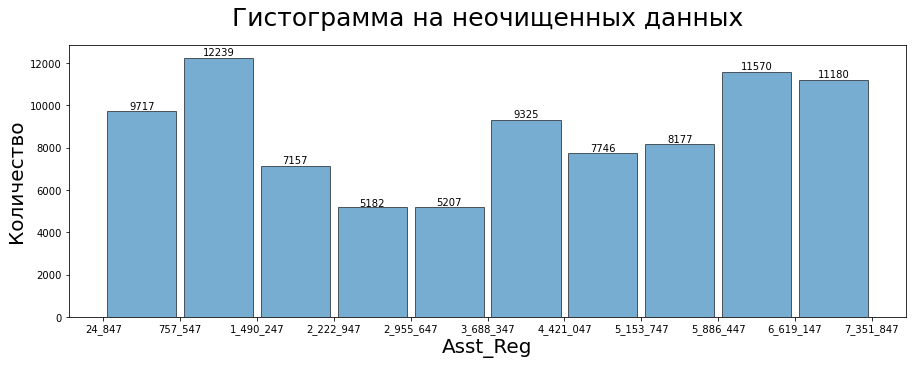

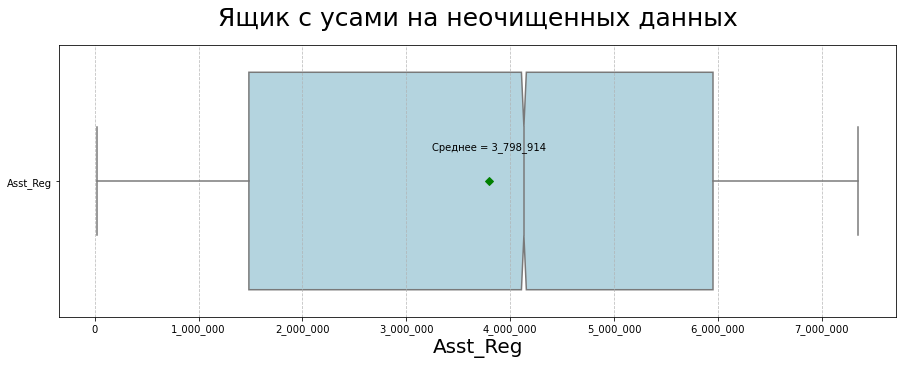

In [15]:
get_histogram(clean_data, 'Asst_Reg', 'неочищенных', 10)
get_boxplot(clean_data, 'Asst_Reg', 'неочищенных');

In [16]:
print(f"Количество выбросов = {get_outliers_mask(clean_data, 'Asst_Reg').sum()}")

Количество выбросов = 0


Распределение похоже на равномерное, отклоняющихся значений нет. Выбросов также не наблюдается, поля остается без изменений <br>

## GGGrade - Оценка группы выдачи кредита

#### Данный признак - категориальный

In [17]:
check_missings('GGGrade')

Поле GGGrade не имеет пропусков!


Нет отсутствующих значений

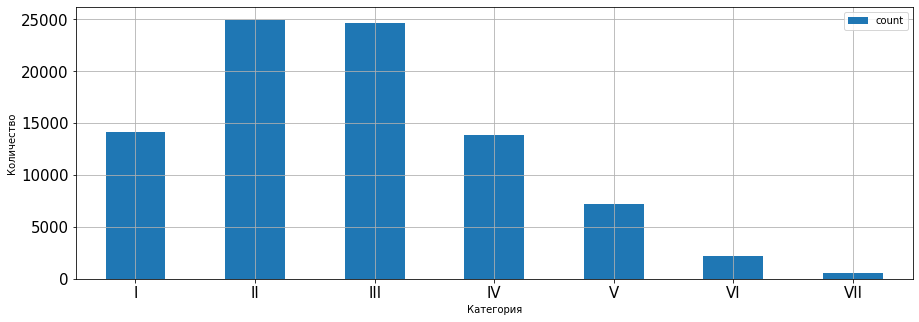

In [18]:
clean_data.GGGrade.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Категория',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=15,
    grid=True
    
)
plt.show()

Исходя из распределния можно сделать вывод, что категория I - это самые лучшие заёмщики, а имеющие оценку VII - наихудшие. <br>
Следовательно данная величина **ORDINAL** - те, которым важен порядок (богатый/бедный или Старшая/Средняя) (LABEL ENCODER) 

In [19]:
sorted(raw_data['GGGrade'].unique(), reverse=True)

['VII', 'VI', 'V', 'IV', 'III', 'II', 'I']

In [20]:
grade_encoder = OrdinalEncoder(categories=[
    [
        'VII', 
        'VI', 
        'V', 
        'IV', 
        'III', 
        'II', 
        'I'
    ]
])

In [21]:
clean_data['GGGrade'] = grade_encoder.fit_transform(clean_data.loc[:, ['GGGrade']])

In [22]:
pd.DataFrame({
    'Origin': raw_data.loc[:, 'GGGrade'].tolist(),
    'Encoded': clean_data.loc[:, 'GGGrade'].tolist(),
})[:20]

,Origin,Encoded
0,II,5.00
1,IV,3.00
2,III,4.00
3,III,4.00
4,V,2.00
5,II,5.00
6,III,4.00
7,III,4.00
8,VII,0.00
9,II,5.00


## Experince - Общий стаж работы заемщика в годах

In [23]:
check_missings('Experince')

Поле Experince не имеет пропусков!


In [24]:
clean_data['Experience'].value_counts()

Experience
>10yrs    30849
2yrs       8064
3yrs       7350
<1yr       7209
1yrs       5853
5yrs       5623
4yrs       5324
7yrs       4762
8yrs       4604
6yrs       4255
9yrs       3607
Name: count, dtype: int64

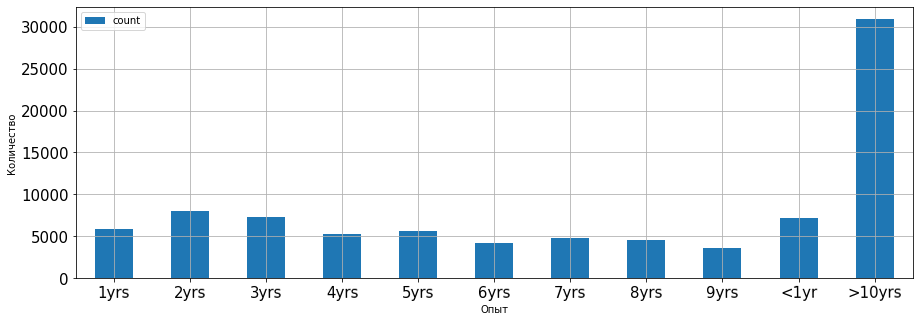

In [25]:
raw_data.Experience.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Опыт',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=15,
    grid=True
    
)
plt.show()

In [26]:
experience_encoder = OrdinalEncoder(categories=[
    [
        '<1yr',
        '1yrs',
        '2yrs', 
        '3yrs', 
        '4yrs', 
        '5yrs',
        '6yrs',
        '7yrs',
        '8yrs', 
        '9yrs',  
        '>10yrs'
    ]
])

In [27]:
clean_data['Experience'] = experience_encoder.fit_transform(clean_data[['Experience']])

In [28]:
pd.DataFrame({
    'Origin': raw_data.loc[:, 'Experience'].tolist(),
    'Encoded': clean_data.loc[:, 'Experience'].tolist(),
})[:20]

,Origin,Encoded
0,>10yrs,10.00
1,7yrs,7.00
2,<1yr,0.00
3,<1yr,0.00
4,2yrs,2.00
5,1yrs,1.00
6,>10yrs,10.00
7,4yrs,4.00
8,<1yr,0.00
9,2yrs,2.00


## Validation - Статус проверки заемщика

In [29]:
check_missings('Validation')

Поле Validation не имеет пропусков!


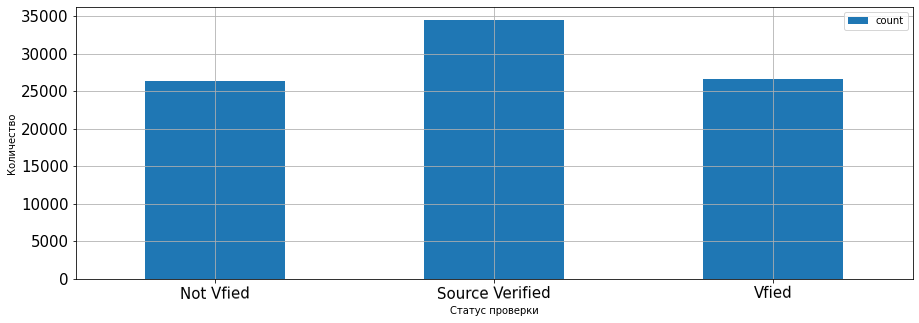

In [30]:
raw_data.Validation.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Статус проверки',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=15,
    grid=True
    
)
plt.show()

Данная величина также ординальная, так как подтверждённые заёмщики (статус = Vfied) для банка более предпочтительны (Лучше) чем неподтверждённые (Not Vfied)

In [31]:
raw_data.Validation.unique()

array(['Vfied', 'Source Verified', 'Not Vfied'], dtype=object)

In [32]:
validation_encoder = OrdinalEncoder(categories=[
    [
        'Not Vfied',
        'Source Verified',
        'Vfied',
    ]
])

In [33]:
clean_data['Validation'] = validation_encoder.fit_transform(clean_data[['Validation']])

In [34]:
pd.DataFrame({
    'Origin': raw_data.loc[:, 'Validation'].tolist(),
    'Encoded': clean_data.loc[:, 'Validation'].tolist(),
})[:10]

,Origin,Encoded
0,Vfied,2.00
1,Source Verified,1.00
2,Source Verified,1.00
3,Vfied,2.00
4,Source Verified,1.00
5,Source Verified,1.00
6,Source Verified,1.00
7,Source Verified,1.00
8,Vfied,2.00
9,Not Vfied,0.00


## Yearly Income - Общий годовой доход заемщика

In [35]:
check_missings('Yearly_Income')

Поле Yearly_Income имеет 5575 пропусков


**Присутствуют** отсуствующие значений

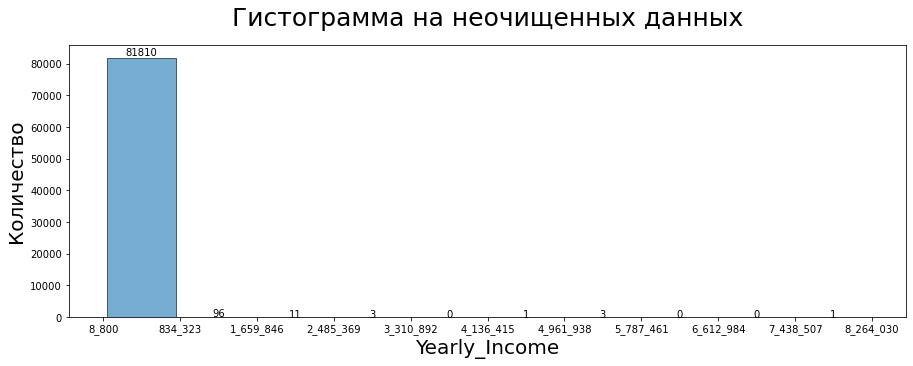

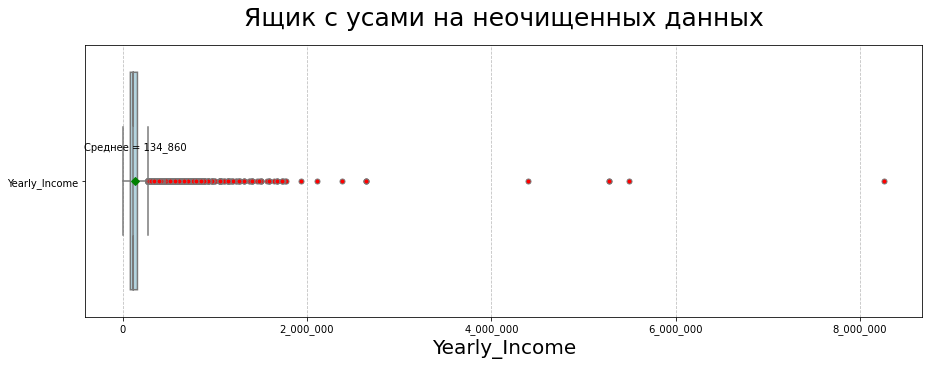

In [36]:
get_histogram(clean_data, 'Yearly_Income', 'неочищенных', 10)
get_boxplot(clean_data, 'Yearly_Income', 'неочищенных');

Из графиков можем сделать вывод, что также присуствуют выбросы <br>
Сначала заменим выбросы на пустые значения, а затем постараемся заменить все пустые значения

In [37]:
m = get_outliers_mask(clean_data, 'Yearly_Income', 0.0, 0.96)
print(f'Количество выбросов = {m.sum()}')
clean_data.loc[m, 'Yearly_Income'] = np.nan

Количество выбросов = 172


In [38]:
clean_data.Yearly_Income.isna().sum()

5747

In [39]:
grade_division = clean_data.groupby('GGGrade').agg({
    'Yearly_Income': np.median,
    'Debt_to_Income': np.median,
    'Present_Balance': np.median,
    'Total_Unpaid_CL': np.median,
    'Unpaid_Amount': np.median,
    'Account_Open': np.mean
    
})
grade_division

,Yearly_Income,Debt_to_Income,Present_Balance,Total_Unpaid_CL,Unpaid_Amount,Account_Open
GGGrade,,,,,,
0.00,117_920.00,33.37,123_275.23,31_457.00,19_112.67,13.25
1.00,114_400.00,33.63,117_484.50,32_204.00,19_875.33,12.68
2.00,109_120.00,34.30,119_257.20,34_860.00,20_709.81,12.93
3.00,105_600.00,33.30,113_855.59,33_366.00,19_614.56,12.81
4.00,109_120.00,31.23,123_576.66,36_022.00,20_395.17,12.67
5.00,114_400.00,28.53,142_025.98,40_504.00,20_773.94,12.63
6.00,137_280.00,25.99,224_436.31,59_760.00,23_599.71,13.13


Изначально я попробовал заменить отсутвующие значения (включая выбросы) в зависимости от медианного значения в выборке по той же профессии. Однако в процессе узнал, что есть професси, которыми занят только один человек и у него отсутсвует годовой доход. <br>
Соответственно, мною было принято решение решение заменять годовой доход исходя из Оценки заёмщика (GGGrade). Предлагается для каждого заёмщика у которого отсутвует значения Yearly_Income посмотреть к какой группе по оценке он относится, затем взять медианное значение годового дохода это группы, сделать диапозон отклонения +- 25% и выбрать рандомное число из этого диапозона.

In [40]:
def fill_missing(row, feature, help_tab):
    current_grade = row['GGGrade']
    group_median = help_tab.loc[current_grade, feature]
    lower = group_median*0.75
    upper = group_median*1.25
    value_to_replace = np.random.uniform(low=lower, high=upper, size=1).item()
    return value_to_replace
    
    

In [41]:
mask = clean_data.Yearly_Income.isna()
clean_data.loc[mask, 'Yearly_Income'] = clean_data.loc[mask, :]\
    .progress_apply(
    lambda x: fill_missing(x, 'Yearly_Income', grade_division), 
    axis=1
)

  0%|          | 0/5747 [00:00<?, ?it/s]

In [42]:
clean_data.Yearly_Income.isna().sum()

0

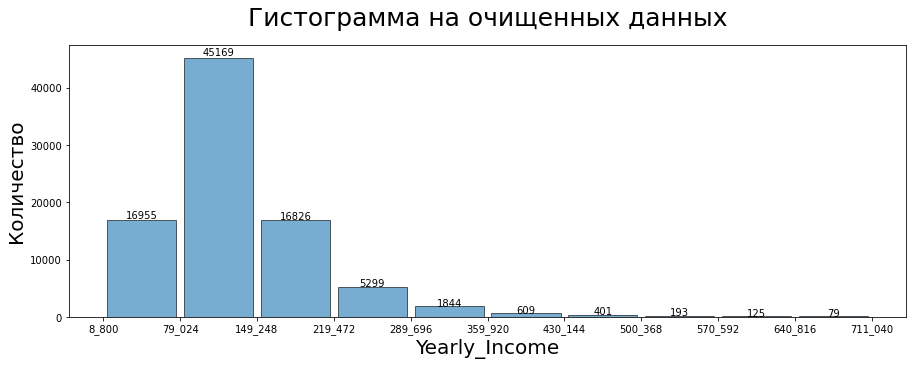

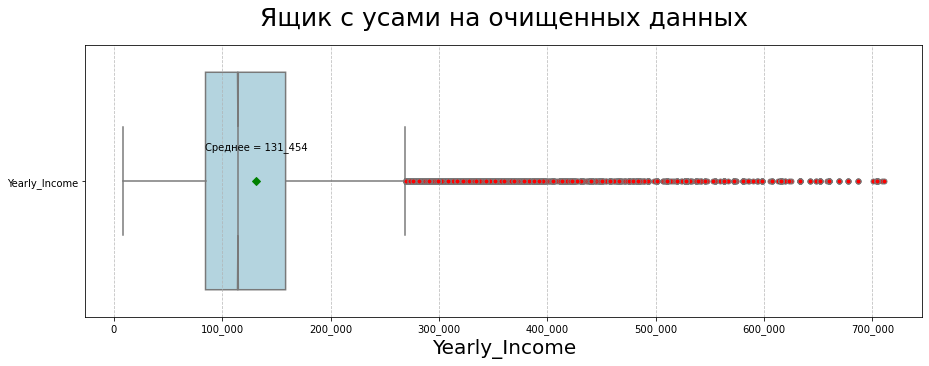

In [43]:
get_histogram(clean_data, 'Yearly_Income', 'очищенных', 10)
get_boxplot(clean_data, 'Yearly_Income', 'очищенных');

Теперь распределение адеватное

## Home Status - Статус проживания заемщика

In [44]:
check_missings('Home_Status')

Поле Home_Status не имеет пропусков!


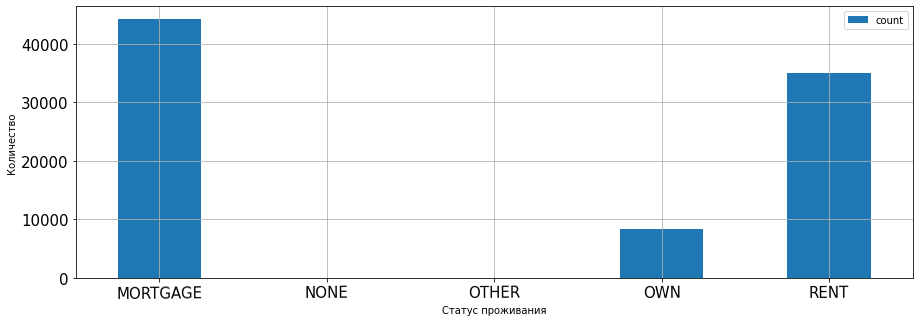

In [45]:
raw_data.Home_Status.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Статус проживания',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=15,
    grid=True
    
)
plt.show()

In [46]:
raw_data.Home_Status.value_counts()

Home_Status
MORTGAGE    44160
RENT        34914
OWN          8416
OTHER           6
NONE            4
Name: count, dtype: int64

In [47]:
home_encoder = OrdinalEncoder(categories=[
    [
        'NONE',
        'OTHER',
        'Vfied',
        'MORTGAGE',
        'RENT',
        'OWN'
    ]
])

In [48]:
clean_data['Home_Status'] = home_encoder.fit_transform(clean_data[['Home_Status']])

In [49]:
pd.DataFrame({
    'Origin': raw_data.loc[:, 'Home_Status'].tolist(),
    'Encoded': clean_data.loc[:, 'Home_Status'].tolist(),
})[:12]

,Origin,Encoded
0,MORTGAGE,3.00
1,RENT,4.00
2,RENT,4.00
3,RENT,4.00
4,RENT,4.00
5,MORTGAGE,3.00
6,RENT,4.00
7,RENT,4.00
8,RENT,4.00
9,OWN,5.00


## Unpaid 2 years - Количество раз, когда заемщик допустил просрочку в течение последних двух лет

In [50]:
check_missings('Unpaid_2_years')

Поле Unpaid_2_years не имеет пропусков!


''

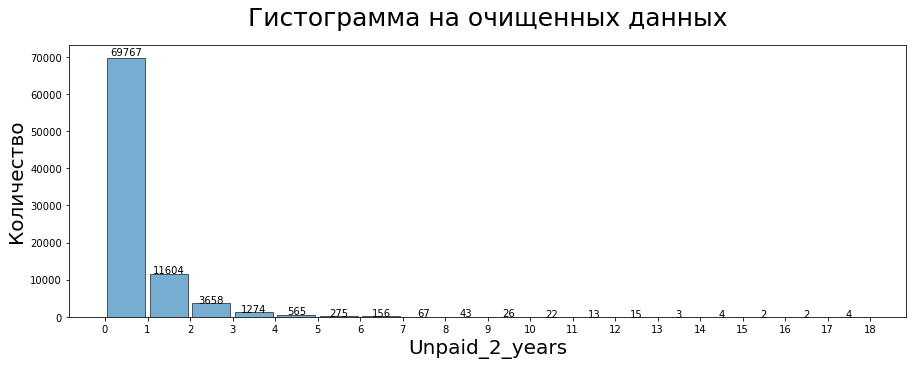

In [51]:
get_histogram(clean_data, 'Unpaid_2_years', 'очищенных', 18)
;

Из графиков может показаться, что с данными что-то не так, однако если погрузиться в суть показателя, то становится понятно, что большинство заёмщиков всё-таки просрачивали платёж 0 раз, иногда 1-2 раза, крайне редко 3-6 раз, ну и единичные случаи вплоть до 18 раз *это ещё в пределах 24 месяцев (2 года)

## Already Defaulted - Количество других кредитов, по которым заемщик допустил просрочку

In [52]:
check_missings('Already_Defaulted')

Поле Already_Defaulted не имеет пропусков!


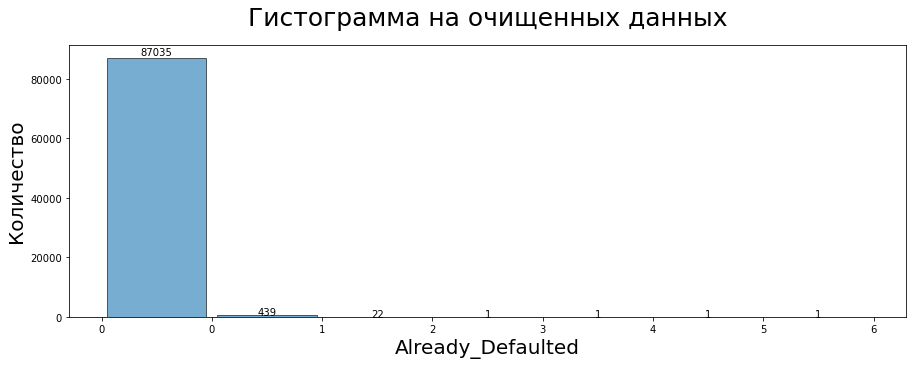

In [53]:
get_histogram(clean_data, 'Already_Defaulted', 'очищенных', 7);

Аналогично прошлому признаку

## Designation - Должность заемщика

In [54]:
check_missings('Designation')

Поле Designation имеет 1414 пропусков


In [55]:
clean_data.Designation.isna().sum()

1414

Заполним выбросы <br>
Для каждой категории оценок выделим 3 самых частых профессии

In [56]:
designation_by_grade = pd.DataFrame(
    columns=['Designation'],
    index=sorted(clean_data.GGGrade.unique())
)
designation_by_grade.index.name = 'GGGrade'

In [57]:
for i in range(0,7):
    df_tmp = clean_data.loc[clean_data.GGGrade == i, 'Designation'].value_counts().to_frame()
    most_common_designations = df_tmp.iloc[0:3,:].index.tolist()
    new_designation = random.choice(most_common_designations)
    designation_by_grade.loc[i, 'Designation'] = new_designation
    

In [58]:
designation_by_grade

,Designation
GGGrade,
0.00,Owner
1.00,School Teacher
2.00,Super Lead
3.00,Owner
4.00,School Teacher
5.00,Nurse
6.00,Super Lead


In [59]:
def fill_designation(row, feature, help_tab):
    grade_group = row['GGGrade']
    new_designation = help_tab.loc[grade_group, feature]
    return new_designation

In [60]:
mask = clean_data.Designation.isna()
clean_data.loc[mask,'Designation'] = clean_data.loc[mask,:]\
    .progress_apply(lambda x: fill_designation(x, 'Designation', designation_by_grade), axis=1)

  0%|          | 0/1414 [00:00<?, ?it/s]

In [61]:
clean_data.Designation.isna().sum()

0

In [62]:
designation_encoder = LabelEncoder()
clean_data.loc[:, 'Designation'] = clean_data.loc[:, ['Designation']]\
    .apply(designation_encoder.fit_transform)

In [63]:
clean_data.head()

,Asst_Reg,GGGrade,Experience,Validation,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Designation,Debt_to_Income,Postal_Code,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,File_Status,State,Account_Open,Total_Unpaid_CL,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
95074,421802,5.00,10.00,2.00,633_600.00,3.00,0,0,12862,12.55,91_300.00,42_023.25,0,15.39,88.92,3,607_161.90,0.00,19,fully paid,California,17,58_598.00,3 years,31_216.05,debt consolidation,I,0.00,0
134131,3964312,3.00,7.00,1.00,85_483.20,4.00,0,0,4177,9.00,27_400.00,38_133.00,0,9.94,102.86,0,269_234.06,0.00,30,whole,NC,15,18_924.00,5 years,11_660.49,debt consolidation,I,0.00,0
92602,4247560,4.00,0.00,1.00,79_200.00,4.00,0,0,36011,24.91,32_800.00,17_100.00,0,22.35,60.37,0,22_476.53,0.00,25,whole,Florida,7,15_604.00,5 years,5_637.87,major purchase,I,0.00,0
22591,197179,4.00,0.00,2.00,61_600.00,4.00,0,0,2918,16.58,7_000.00,5_130.00,0,10.36,116.27,1,15_242.09,0.00,22,fully paid,NewJersey,9,22_410.00,3 years,15_607.17,major purchase,I,0.00,1
125060,4646684,2.00,2.00,1.00,68_053.92,4.00,0,0,16887,40.05,70_800.00,19_665.00,0,13.68,127.28,1,65_433.94,0.00,32,fully paid,LA,10,36_022.00,5 years,27_472.86,debt consolidation,I,0.00,0


## Debt to Income - Соотношение долга к доходу

In [64]:
check_missings('Debt_to_Income')

Поле Debt_to_Income имеет 3489 пропусков


In [65]:
clean_data.Debt_to_Income.isna().sum()

3489

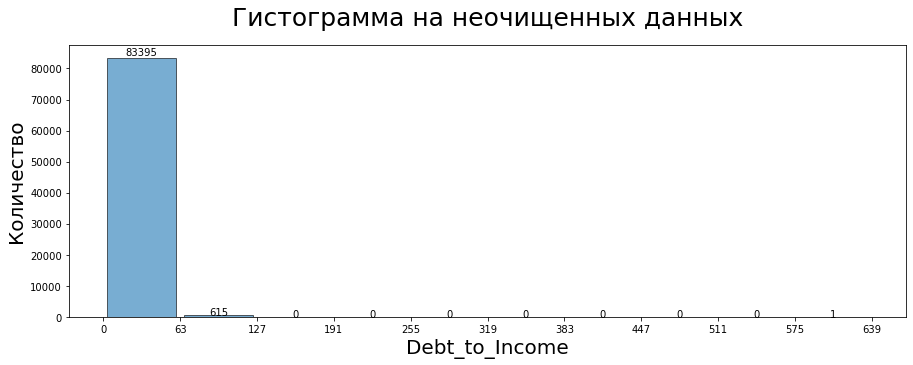

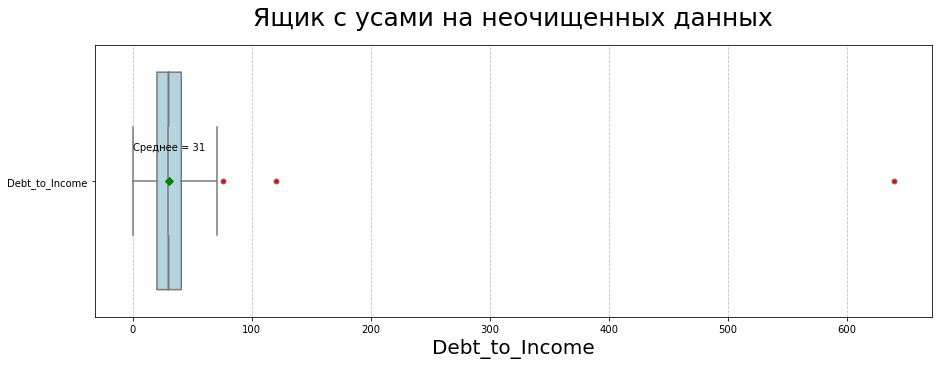

In [66]:
get_histogram(raw_data, 'Debt_to_Income', 'неочищенных', 10)
get_boxplot(raw_data, 'Debt_to_Income', 'неочищенных');

Есть выбросы, единичные

In [67]:
m = get_outliers_mask(clean_data, 'Debt_to_Income', 0.0, 0.72)
print(f'Количество выбросов = {m.sum()}')
clean_data.loc[m, 'Debt_to_Income'] = np.nan

Количество выбросов = 2


In [68]:
mask = clean_data.Debt_to_Income.isna()
clean_data.loc[mask, 'Debt_to_Income'] = clean_data.loc[mask, :]\
    .progress_apply(
    lambda x: fill_missing(x, 'Debt_to_Income', grade_division), 
    axis=1
)

  0%|          | 0/3491 [00:00<?, ?it/s]

In [69]:
clean_data.Debt_to_Income.isna().sum()

0

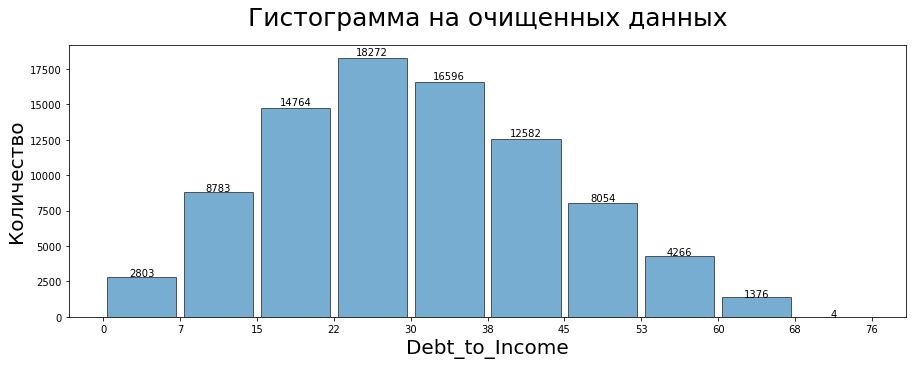

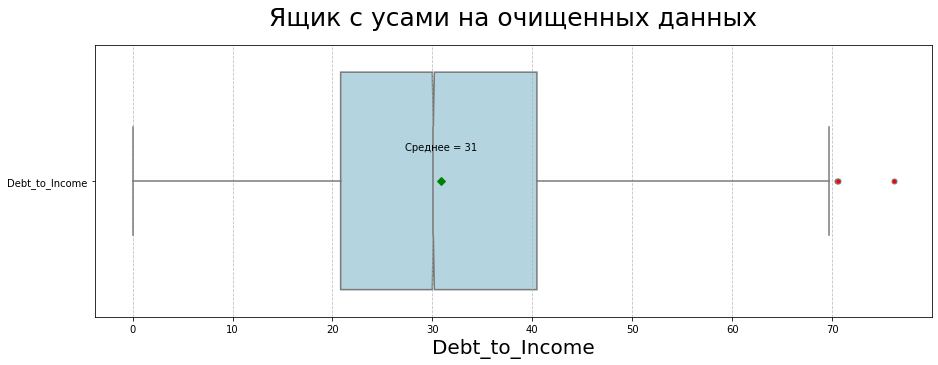

In [70]:
get_histogram(clean_data, 'Debt_to_Income', 'очищенных', 10)
get_boxplot(clean_data, 'Debt_to_Income', 'очищенных');

## Postal Code - Почтовый индекс заемщика

Данное поле не несёт никакой смысловой нагрузки для риска, поэтому эту колонку можно удалить

In [71]:
clean_data.drop(columns=['Postal_Code'], inplace=True)

## Lend Amount - Общая сумма кредита, выданная заемщику

In [72]:
check_missings('Lend_Amount')

Поле Lend_Amount не имеет пропусков!


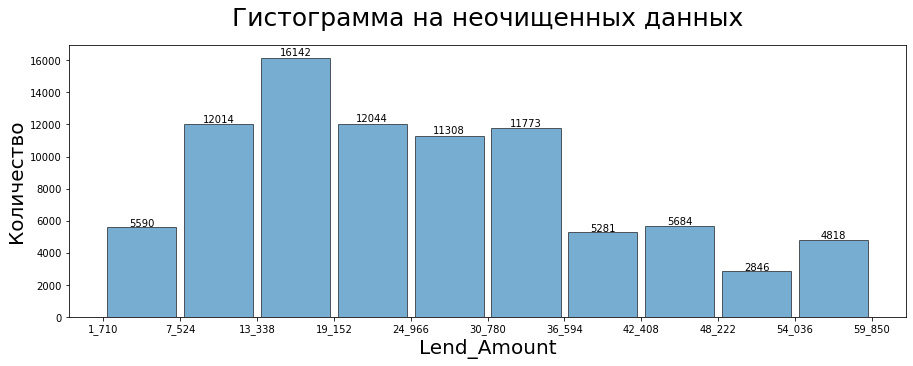

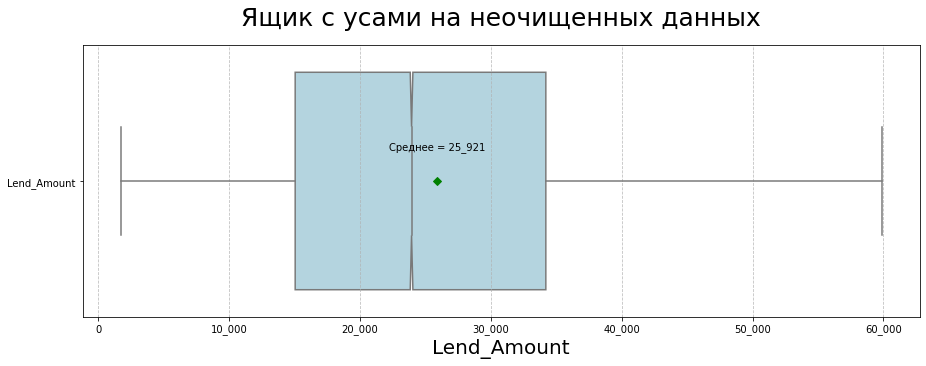

In [73]:
get_histogram(raw_data, 'Lend_Amount', 'неочищенных', 10)
get_boxplot(raw_data, 'Lend_Amount', 'неочищенных');

##### Данные хорошие, без выбросов

## Deprecatory Records - Запись, которая может рассматриваться кредиторами как негативная, так как она указывает на риск и ухудшает возможность получения кредита или других услуг

In [74]:
check_missings('Deprecatory_Records')

Поле Deprecatory_Records не имеет пропусков!


In [75]:
clean_data.loc[:, 'Deprecatory_Records'].value_counts()

Deprecatory_Records
0     73827
1     11354
2      1481
3       465
4       193
5        85
6        39
7        24
8        14
10        7
9         3
16        2
12        1
86        1
11        1
13        1
22        1
15        1
Name: count, dtype: int64

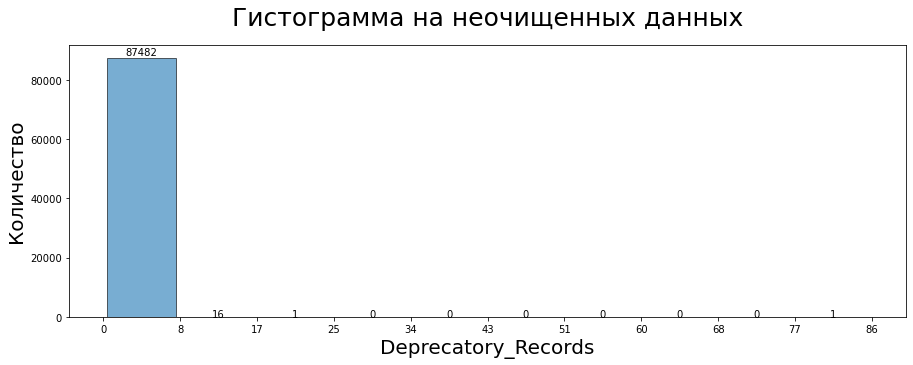

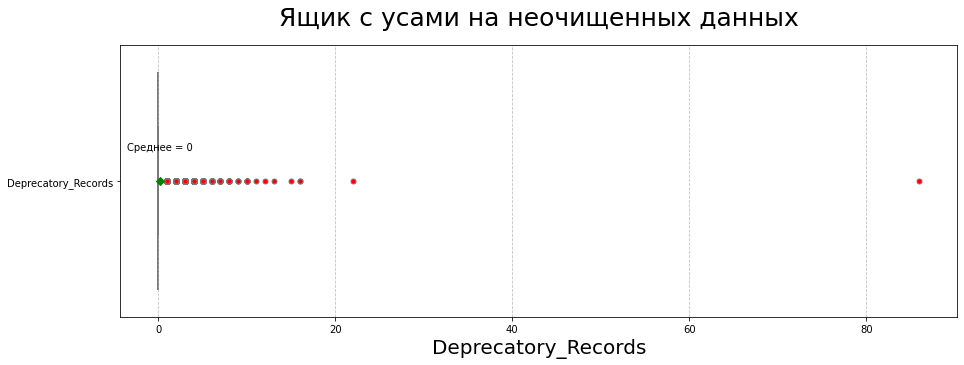

In [76]:
get_histogram(raw_data, 'Deprecatory_Records', 'неочищенных', 10)
get_boxplot(raw_data, 'Deprecatory_Records', 'неочищенных');

## Interest Charged - Процентная ставка по общей сумме кредита

In [77]:
check_missings('Interest_Charged')

Поле Interest_Charged не имеет пропусков!


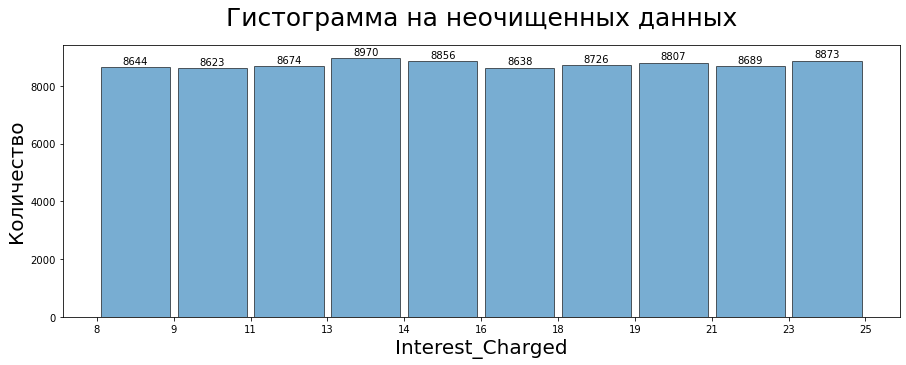

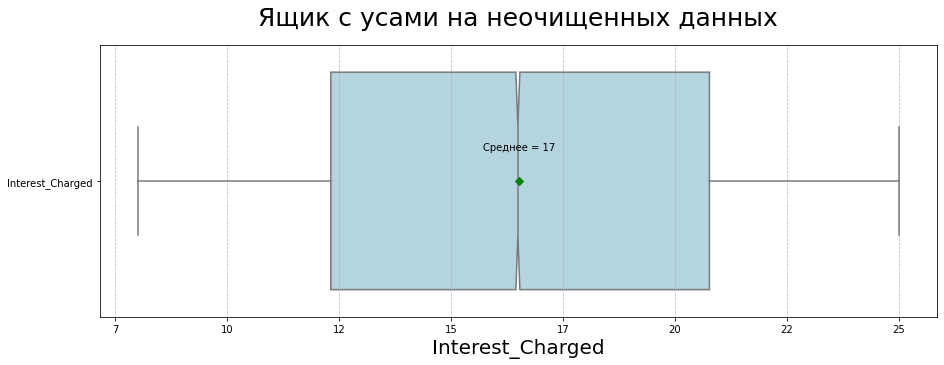

In [78]:
get_histogram(raw_data, 'Interest_Charged', 'неочищенных', 10)
get_boxplot(raw_data, 'Interest_Charged', 'неочищенных');

Распределение похоже на равномерное. Выбросов не наблюдается

## Usage Rate - Обработочные сборы на сумму кредита

In [79]:
check_missings('Usage_Rate')

Поле Usage_Rate не имеет пропусков!


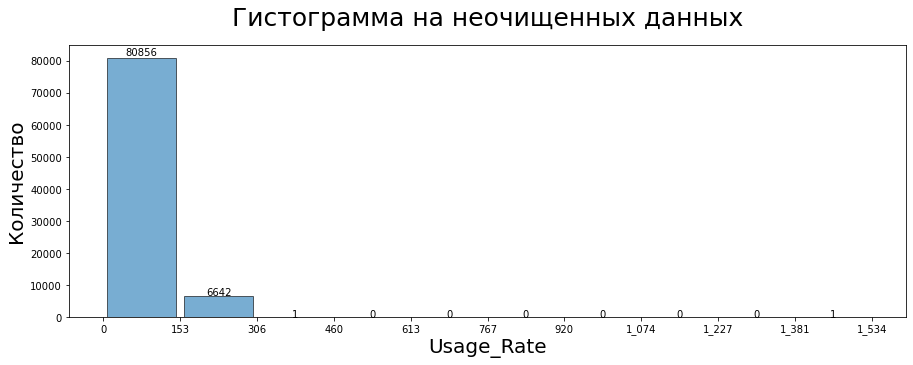

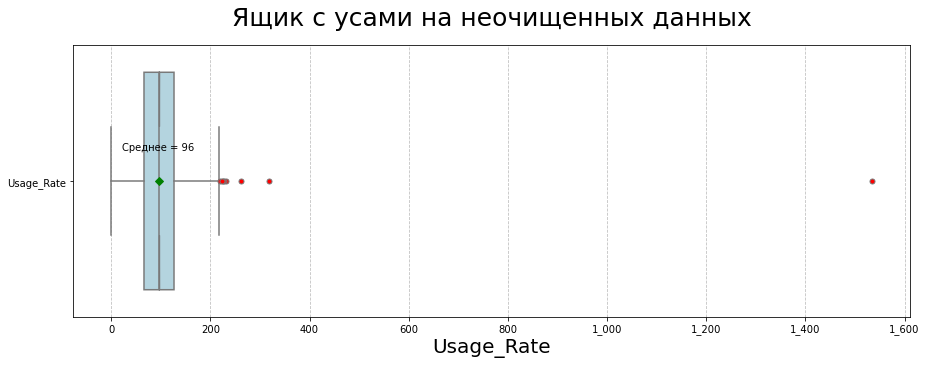

In [80]:
get_histogram(raw_data, 'Usage_Rate', 'неочищенных', 10)
get_boxplot(raw_data, 'Usage_Rate', 'неочищенных');

Есть выбросы, но их немного

In [81]:
m = get_outliers_mask(clean_data, 'Usage_Rate', 0.0, 0.5)
print(f'Количесвто выбросов: {m.sum()}')
clean_data.loc[m, 'Usage_Rate'] = clean_data.loc[~m, 'Usage_Rate'].max()

Количесвто выбросов: 3


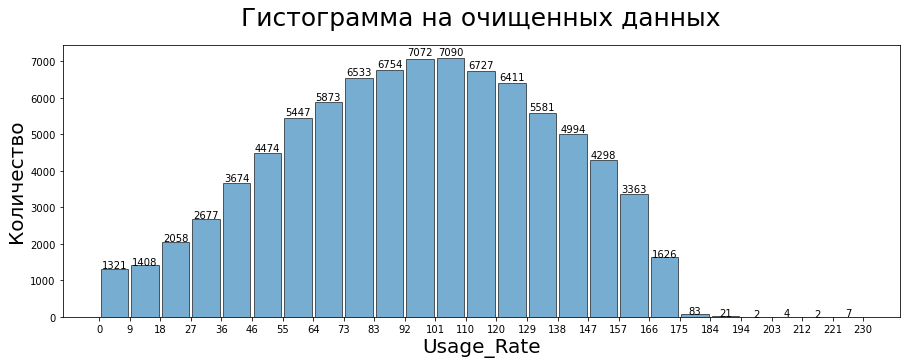

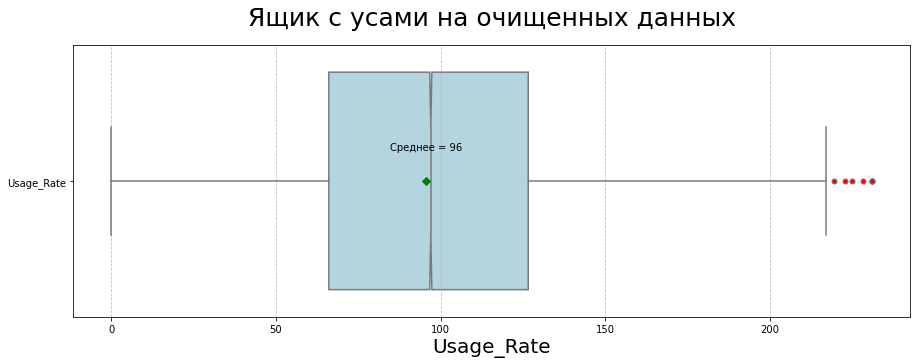

In [82]:
get_histogram(clean_data, 'Usage_Rate', 'очищенных', 25)
get_boxplot(clean_data, 'Usage_Rate', 'очищенных');

Теперь распределние похоже на нормальное

## Inquiries - Запросы за последние 6 месяцев

In [83]:
check_missings('Inquiries')

Поле Inquiries не имеет пропусков!


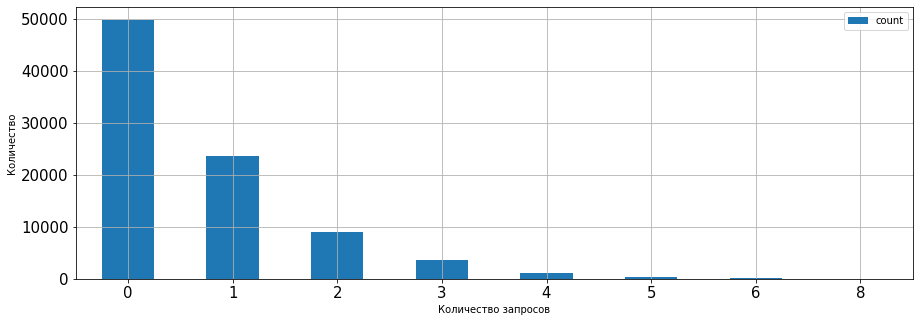

In [84]:
raw_data.Inquiries.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Количество запросов',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=15,
    grid=True
    
)
plt.show()

Исходя их смысла показателя данное распределение является адекватным, так как большинство людей делали 0 запросов (им возможно не нужны кредиты)

## Present Balance - Текущий баланс на счету заемщика

In [85]:
check_missings('Present_Balance')

Поле Present_Balance не имеет пропусков!


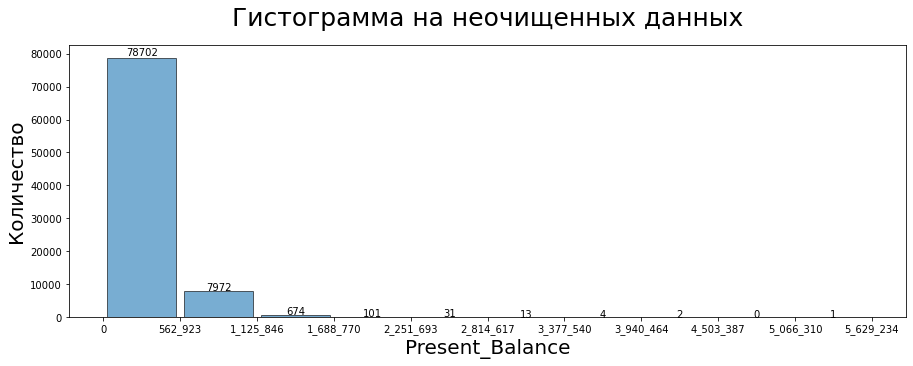

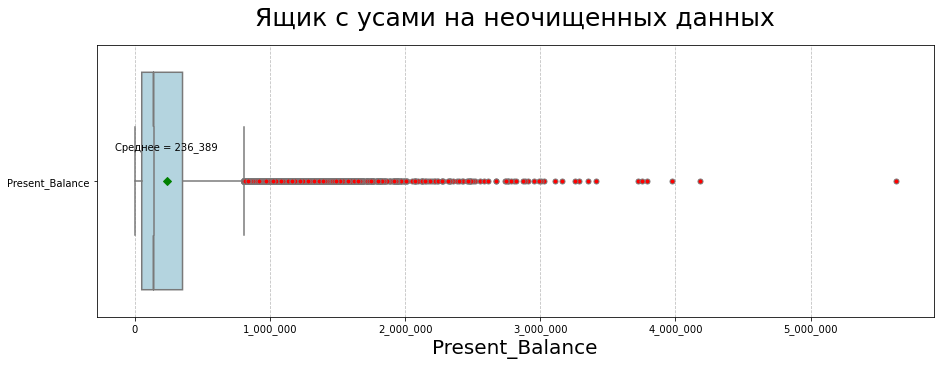

In [86]:
get_histogram(raw_data, 'Present_Balance', 'неочищенных', 10)
get_boxplot(raw_data, 'Present_Balance', 'неочищенных');

In [87]:
m = get_outliers_mask(clean_data, 'Present_Balance', 0.0, 0.95)
print(f'Количесвто выбросов: {m.sum()}')
clean_data.loc[m, 'Present_Balance'] = np.nan

Количесвто выбросов: 120


In [88]:
grade_division

,Yearly_Income,Debt_to_Income,Present_Balance,Total_Unpaid_CL,Unpaid_Amount,Account_Open
GGGrade,,,,,,
0.00,117_920.00,33.37,123_275.23,31_457.00,19_112.67,13.25
1.00,114_400.00,33.63,117_484.50,32_204.00,19_875.33,12.68
2.00,109_120.00,34.30,119_257.20,34_860.00,20_709.81,12.93
3.00,105_600.00,33.30,113_855.59,33_366.00,19_614.56,12.81
4.00,109_120.00,31.23,123_576.66,36_022.00,20_395.17,12.67
5.00,114_400.00,28.53,142_025.98,40_504.00,20_773.94,12.63
6.00,137_280.00,25.99,224_436.31,59_760.00,23_599.71,13.13


In [89]:
mask = clean_data.Present_Balance.isna()
clean_data.loc[mask, 'Present_Balance'] = clean_data.loc[mask, :]\
    .progress_apply(
    lambda x: fill_missing(x, 'Present_Balance', grade_division), 
    axis=1
)

  0%|          | 0/120 [00:00<?, ?it/s]

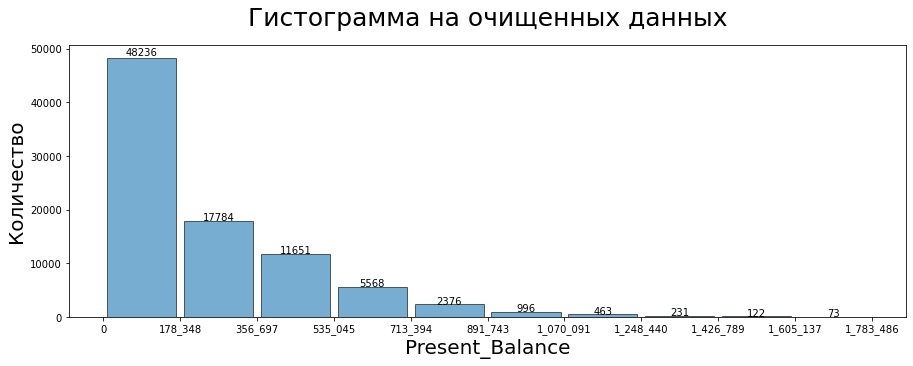

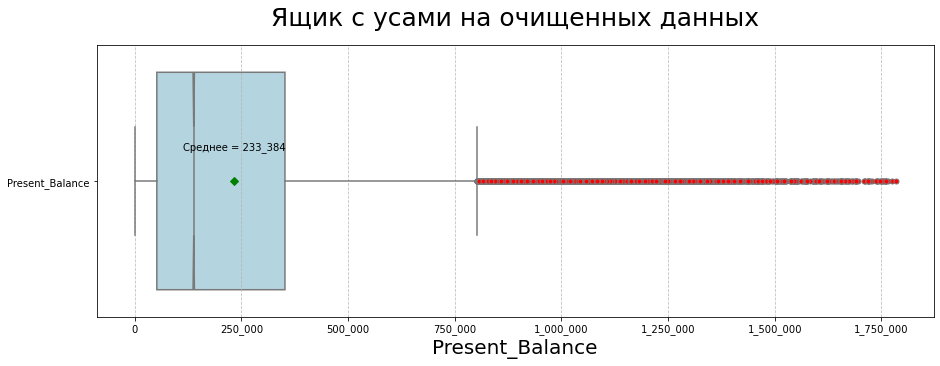

In [90]:
get_histogram(clean_data, 'Present_Balance', 'очищенных', 10)
get_boxplot(clean_data, 'Present_Balance', 'очищенных');

Считаю, что данное распределение уже является адекватным, потому что действительно может быть небольшое количество людей, очень богатых

## Gross Collection - Общая сумма, подлежащая выплате в рамках урегулирования или судебного решения по искам, исключая любые расходы

In [91]:
check_missings('Gross_Collection')

Поле Gross_Collection не имеет пропусков!


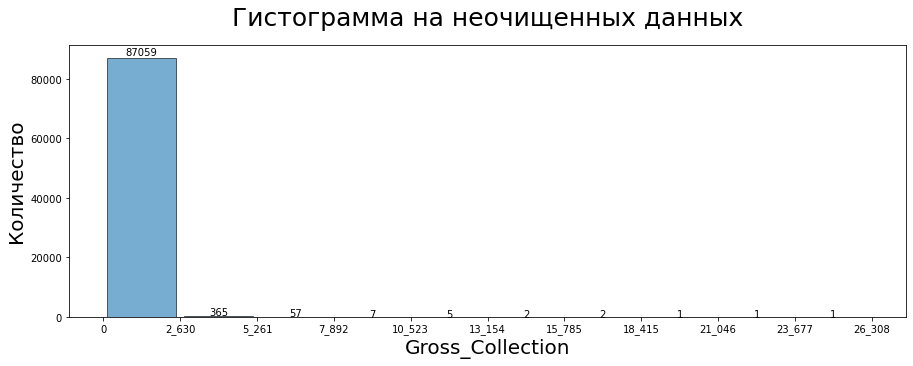

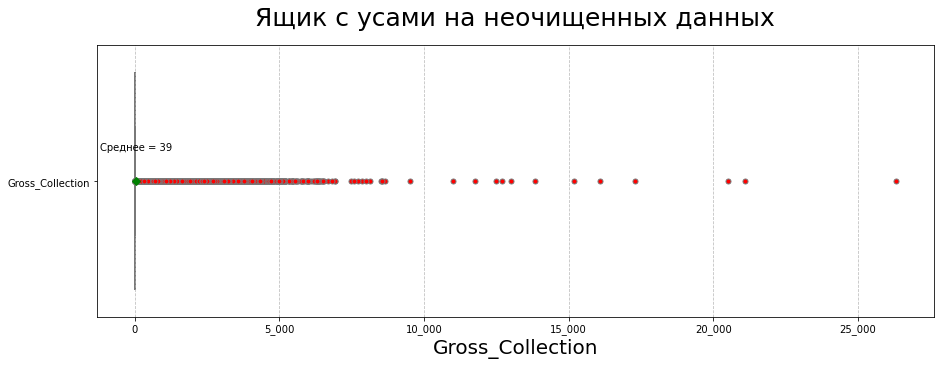

In [92]:
get_histogram(raw_data, 'Gross_Collection', 'неочищенных', 10)
get_boxplot(raw_data, 'Gross_Collection', 'неочищенных');


In [93]:
clean_data.Gross_Collection.value_counts().to_frame()

,count
Gross_Collection,
0.00,85815
2_080.72,2
11.90,2
5_437.55,2
1_200.00,2
...,...
1_054.22,1
803.04,1
2_108.94,1


Для данного поля это адекватное распределение, так как большинство людей всё-таки не имеют судебных задолженностей

## Sub GGGrade - Оценка подгруппы группы выдачи кредита

In [94]:
check_missings('Sub_GGGrade')

Поле Sub_GGGrade не имеет пропусков!


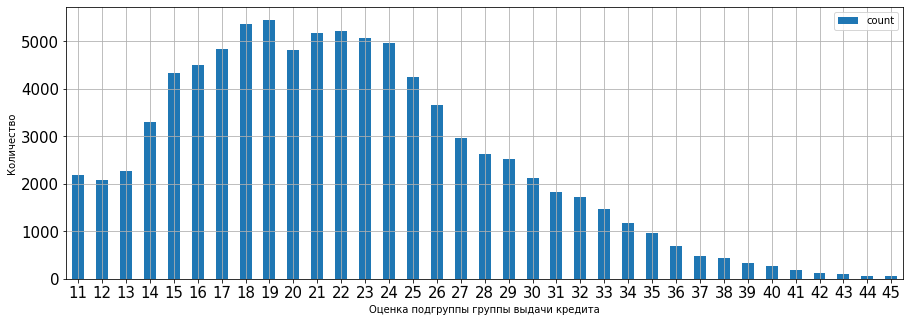

In [95]:
raw_data.Sub_GGGrade.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Оценка подгруппы группы выдачи кредита',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=15,
    grid=True
    
)
plt.show()

Распределение похоже на нормальное

## File Status - Статус заявки на кредит

In [96]:
check_missings('File_Status')

Поле File_Status не имеет пропусков!


In [97]:
clean_data.File_Status.value_counts()

File_Status
whole         46300
fully paid    41200
Name: count, dtype: int64

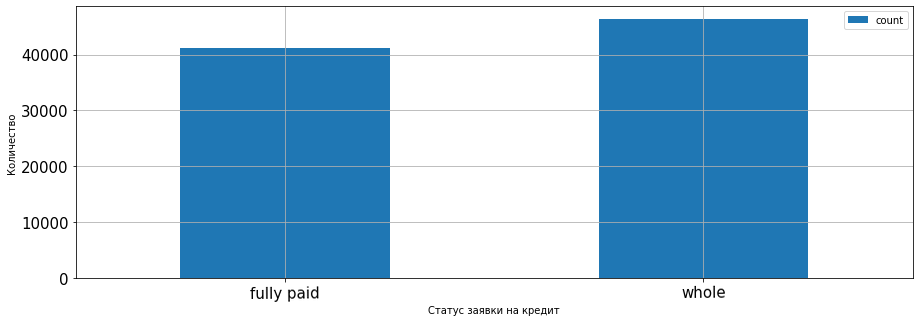

In [98]:
clean_data.File_Status.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Статус заявки на кредит',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=15,
    grid=True
    
)
plt.show()

Данный признак категориальный и номинальный, не ординальный.

In [99]:
file_status_encoder = LabelEncoder()
clean_data.loc[:, 'File_Status'] = clean_data.loc[:, ['File_Status']]\
    .apply(file_status_encoder.fit_transform)

In [100]:
clean_data.head(6)

,Asst_Reg,GGGrade,Experience,Validation,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Designation,Debt_to_Income,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,File_Status,State,Account_Open,Total_Unpaid_CL,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
95074,421802,5.00,10.00,2.00,633_600.00,3.00,0,0,12862,12.55,42_023.25,0,15.39,88.92,3,607_161.90,0.00,19,0,California,17,58_598.00,3 years,31_216.05,debt consolidation,I,0.00,0
134131,3964312,3.00,7.00,1.00,85_483.20,4.00,0,0,4177,9.00,38_133.00,0,9.94,102.86,0,269_234.06,0.00,30,1,NC,15,18_924.00,5 years,11_660.49,debt consolidation,I,0.00,0
92602,4247560,4.00,0.00,1.00,79_200.00,4.00,0,0,36011,24.91,17_100.00,0,22.35,60.37,0,22_476.53,0.00,25,1,Florida,7,15_604.00,5 years,5_637.87,major purchase,I,0.00,0
22591,197179,4.00,0.00,2.00,61_600.00,4.00,0,0,2918,16.58,5_130.00,0,10.36,116.27,1,15_242.09,0.00,22,0,NewJersey,9,22_410.00,3 years,15_607.17,major purchase,I,0.00,1
125060,4646684,2.00,2.00,1.00,68_053.92,4.00,0,0,16887,40.05,19_665.00,0,13.68,127.28,1,65_433.94,0.00,32,0,LA,10,36_022.00,5 years,27_472.86,debt consolidation,I,0.00,0
21803,1771402,5.00,1.00,1.00,219_648.00,3.00,4,0,12023,26.43,34_200.00,0,15.12,115.93,2,60_089.94,0.00,19,1,TX,11,27_556.00,3 years,19_134.90,debt consolidation,I,0.00,0


## State: Штат, к которому принадлежит заемщик

In [101]:
check_missings('State')

Поле State не имеет пропусков!


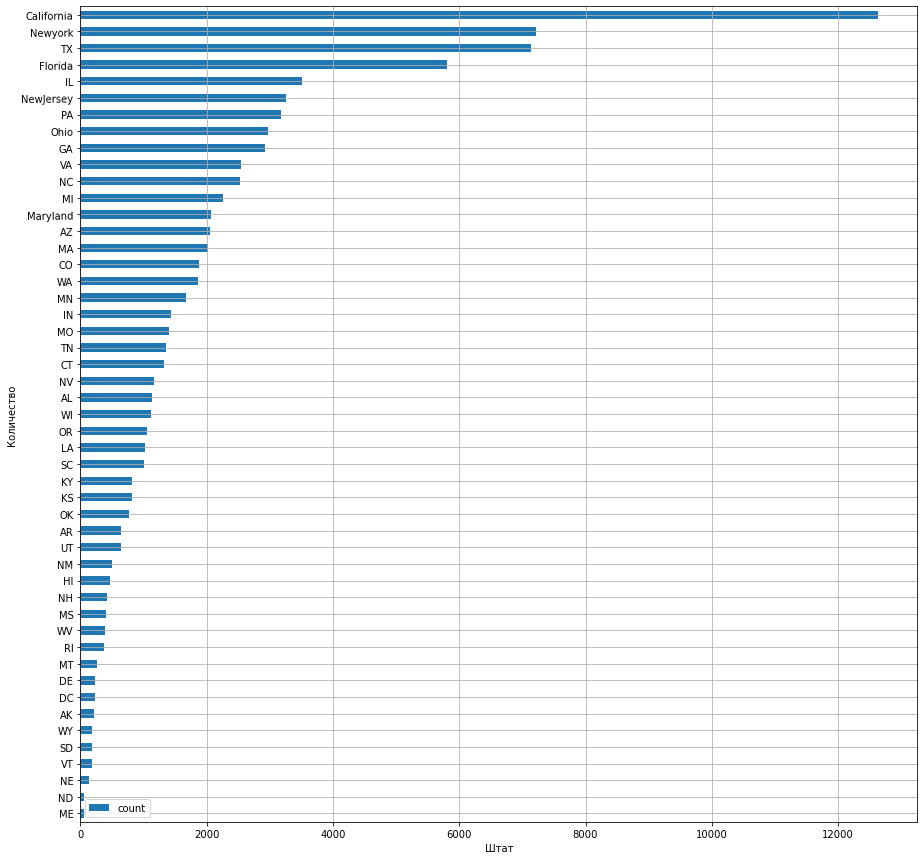

In [102]:
clean_data.State.value_counts()\
    .to_frame()\
    .sort_values('count')\
    .plot(
    kind='barh',
    xlabel='Штат',
    ylabel='Количество',
    figsize=(15,15),
    rot=0.5,
    fontsize=10,
    grid=True
    
)
plt.show()

Распределение адекватное. Признак Категориальный. Номинальный, так как нет прямой зависимости что какой-то из штатов лучше чем другой

In [103]:
state_encoder = LabelEncoder()
clean_data.loc[:, 'State'] = clean_data.loc[:, ['State']]\
    .apply(state_encoder.fit_transform)

In [104]:
clean_data.head(3)

,Asst_Reg,GGGrade,Experience,Validation,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Designation,Debt_to_Income,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,File_Status,State,Account_Open,Total_Unpaid_CL,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
95074,421802,5.00,10.00,2.00,633_600.00,3.00,0,0,12862,12.55,42_023.25,0,15.39,88.92,3,607_161.90,0.00,19,0,6,17,58_598.00,3 years,31_216.05,debt consolidation,I,0.00,0
134131,3964312,3.00,7.00,1.00,85_483.20,4.00,0,0,4177,9.00,38_133.00,0,9.94,102.86,0,269_234.06,0.00,30,1,25,15,18_924.00,5 years,11_660.49,debt consolidation,I,0.00,0
92602,4247560,4.00,0.00,1.00,79_200.00,4.00,0,0,36011,24.91,17_100.00,0,22.35,60.37,0,22_476.53,0.00,25,1,9,7,15_604.00,5 years,5_637.87,major purchase,I,0.00,0


## Account Open - Общее количество открытых счетов на имя заемщика

In [105]:
check_missings('Account_Open')

Поле Account_Open не имеет пропусков!


In [106]:
raw_data.Account_Open.nunique()

59

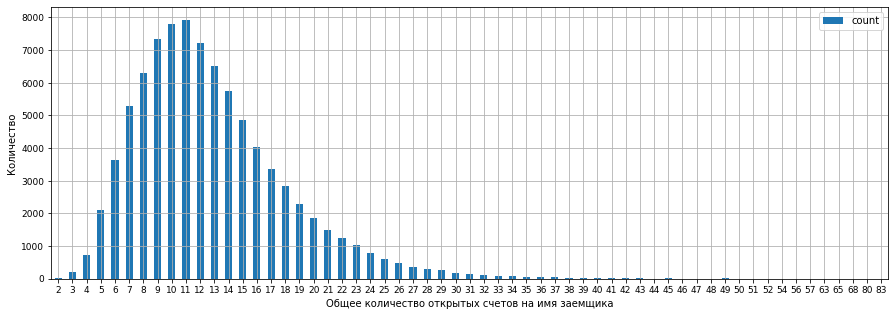

In [107]:
clean_data.Account_Open.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Общее количество открытых счетов на имя заемщика',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=9,
    grid=True
    
)
plt.show()

Похоже, что есть выбросы и по распределени. и по логике: тяжело иметь 40+ счетов

In [108]:
m = get_outliers_mask(clean_data, 'Account_Open', 0.0, 0.8)
print(f'Количесвто выбросов: {m.sum()}')
clean_data.loc[m, 'Account_Open'] = np.nan

Количесвто выбросов: 96


In [109]:
clean_data.Account_Open.fillna(
    float(np.random.randint(
        low= clean_data.Account_Open.quantile(0.15),
        high= clean_data.Account_Open.quantile(0.85)
    )
         ), inplace=True)

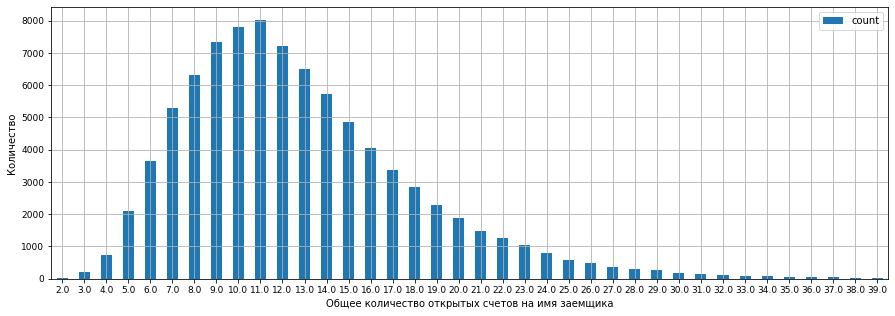

In [110]:
clean_data.Account_Open.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Общее количество открытых счетов на имя заемщика',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=9,
    grid=True
    
)
plt.show()

## Total Unpaid CL - Неоплаченные задолженности по всем другим кредитам

In [111]:
check_missings('Total_Unpaid_CL')

Поле Total_Unpaid_CL имеет 4186 пропусков


In [112]:
missings.style.format('{:.2%}')

,Доля путсых значений
Yearly_Income,6.37%
Designation,1.62%
Debt_to_Income,3.99%
Postal_Code,1.59%
Total_Unpaid_CL,4.78%
Unpaid_Amount,5.55%


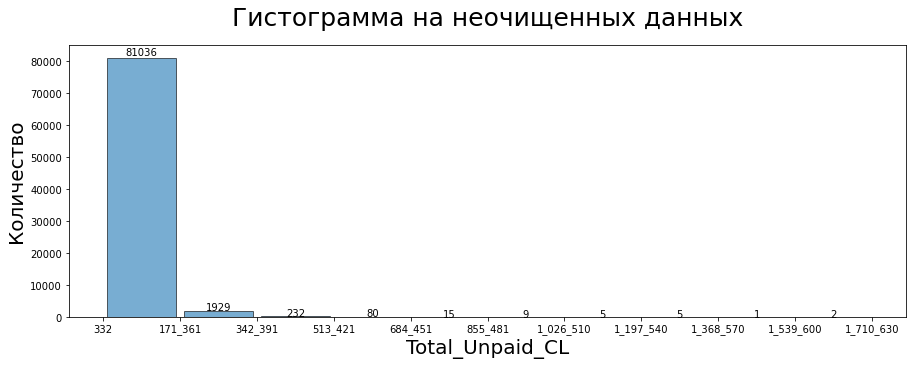

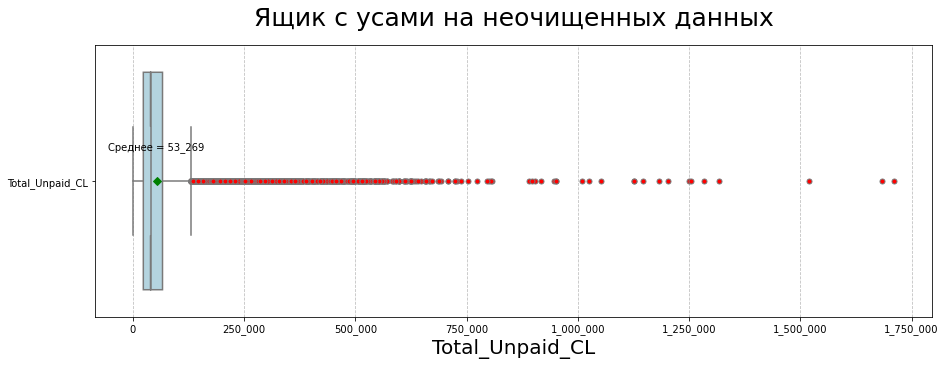

In [113]:
get_histogram(raw_data, 'Total_Unpaid_CL', 'неочищенных', 10)
get_boxplot(raw_data, 'Total_Unpaid_CL', 'неочищенных');

Также наблюдаются выбросы, избавимся от них

In [114]:
m = get_outliers_mask(clean_data, 'Total_Unpaid_CL', 0.0, 0.85)
print(f'Количесвто выбросов: {m.sum()}')
clean_data.loc[m, 'Total_Unpaid_CL'] = np.nan

Количесвто выбросов: 1215


In [115]:
mask = clean_data.Total_Unpaid_CL.isna()
clean_data.loc[mask, 'Total_Unpaid_CL'] = clean_data.loc[mask, :]\
    .progress_apply(
    lambda x: fill_missing(x, 'Total_Unpaid_CL', grade_division), 
    axis=1
)

  0%|          | 0/5401 [00:00<?, ?it/s]

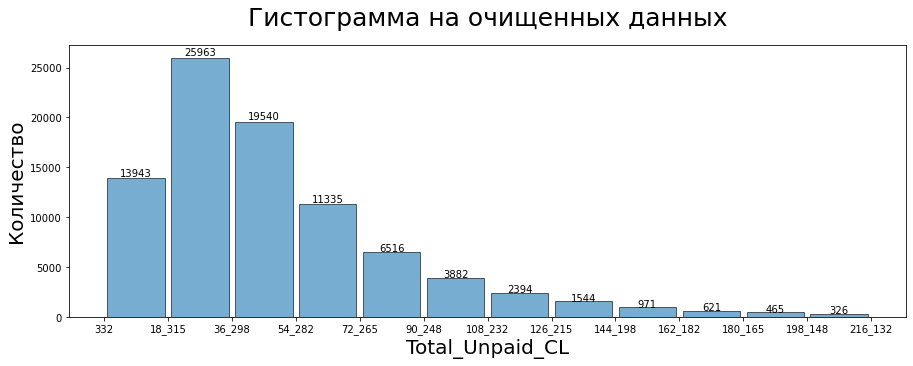

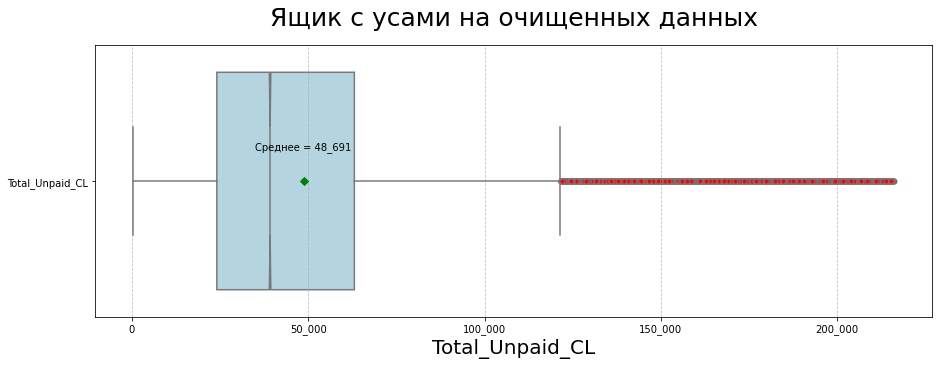

In [116]:
get_histogram(clean_data, 'Total_Unpaid_CL', 'очищенных', 12)
get_boxplot(clean_data, 'Total_Unpaid_CL', 'очищенных');

## Duration - Срок, на который выдан кредит заемщику

In [117]:
check_missings('Duration')

Поле Duration не имеет пропусков!


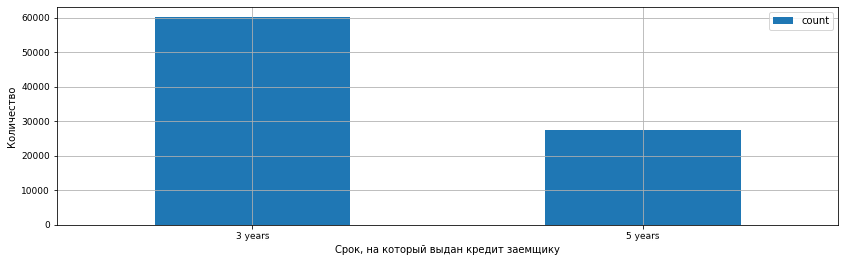

In [118]:
clean_data.Duration.value_counts()\
    .to_frame()\
    .sort_index()\
    .plot(
    kind='bar',
    xlabel='Срок, на который выдан кредит заемщику',
    ylabel='Количество',
    figsize=(14,4),
    rot=0.5,
    fontsize=9,
    grid=True
    
)
plt.show()

Признак категориальный, нужно разбить на числа

In [119]:
clean_data.Duration = clean_data.Duration.str.rstrip(' years').astype(float)

In [120]:
clean_data.loc[:, ['Duration']]

,Duration
ID,
95074,3.00
134131,5.00
92602,5.00
22591,3.00
125060,5.00
...,...
120884,3.00
33259,5.00
102153,3.00


## Unpaid Amount - Неоплаченный баланс по кредитной карте

In [121]:
check_missings('Unpaid_Amount')

Поле Unpaid_Amount имеет 4852 пропусков


In [122]:
missings.style.format('{:.2%}')

,Доля путсых значений
Yearly_Income,6.37%
Designation,1.62%
Debt_to_Income,3.99%
Postal_Code,1.59%
Total_Unpaid_CL,4.78%
Unpaid_Amount,5.55%


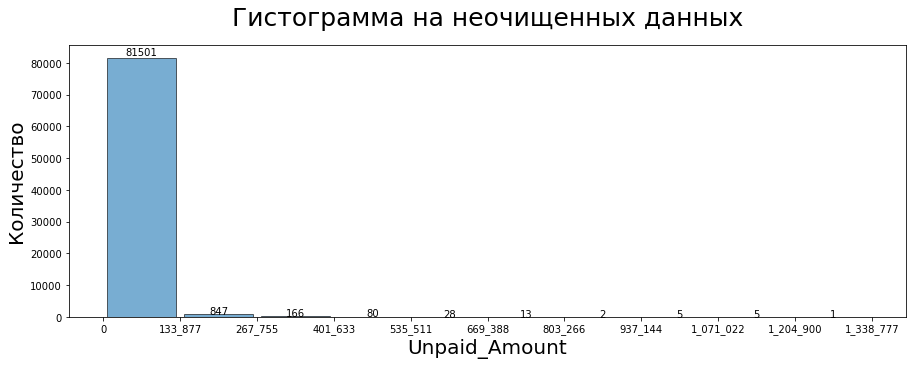

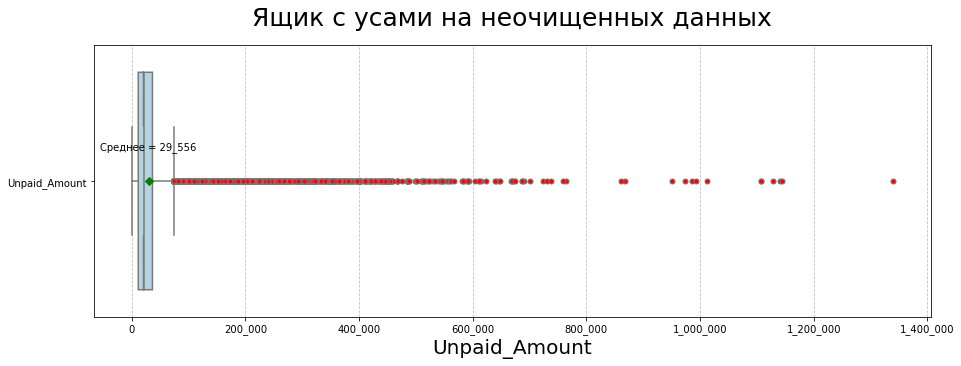

In [123]:
get_histogram(raw_data, 'Unpaid_Amount', 'неочищенных', 10)
get_boxplot(raw_data, 'Unpaid_Amount', 'неочищенных');

Наблюдаются выбросы, изюавимся от них

In [124]:
m = get_outliers_mask(clean_data, 'Unpaid_Amount', 0.0, 0.75)
print(f'Количесвто выбросов: {m.sum()}')
clean_data.loc[m, 'Unpaid_Amount'] = np.nan

Количесвто выбросов: 2497


In [125]:
mask = clean_data.Unpaid_Amount.isna()
clean_data.loc[mask, 'Unpaid_Amount'] = clean_data.loc[mask, :]\
    .progress_apply(
    lambda x: fill_missing(x, 'Unpaid_Amount', grade_division), 
    axis=1
)

  0%|          | 0/7349 [00:00<?, ?it/s]

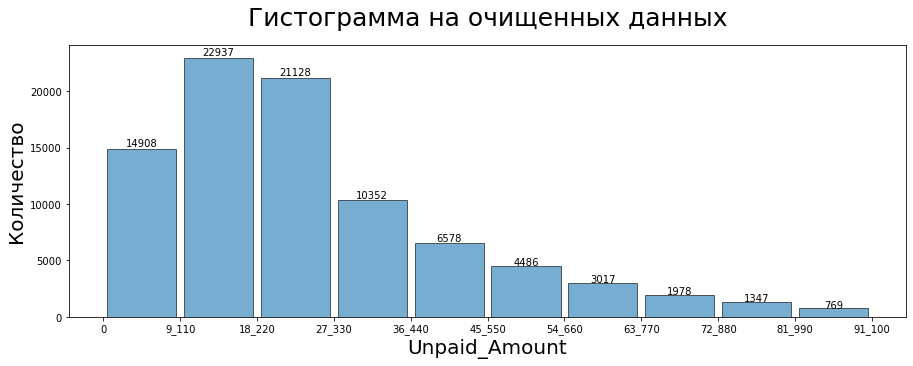

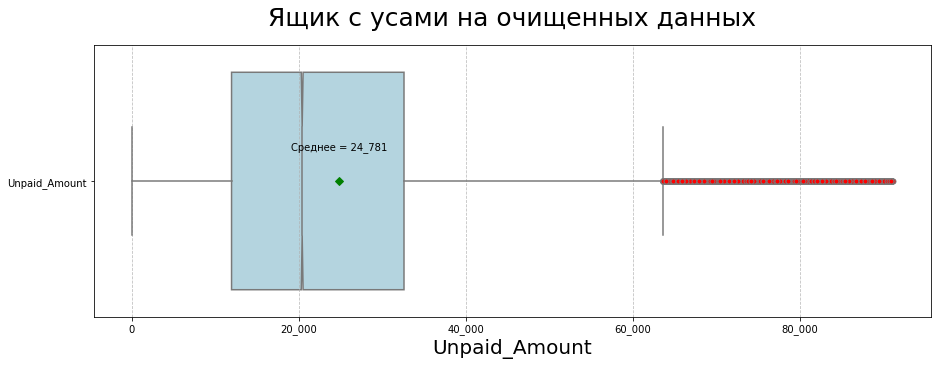

In [126]:
get_histogram(clean_data, 'Unpaid_Amount', 'очищенных', 10)
get_boxplot(clean_data, 'Unpaid_Amount', 'очищенных');

## Reason - Причина подачи заявки на кредит

In [127]:
check_missings('Reason')

Поле Reason не имеет пропусков!


In [128]:
clean_data.Reason.value_counts()

Reason
debt  consolidation    52559
credit  card           21102
home  improvement       4886
other                   3774
major  purchase         1512
medical                  821
small  business          751
car                      710
moving                   503
vacation                 424
house                    311
wedding                  109
RENTwable  energy         38
Name: count, dtype: int64

In [129]:
clean_data.Reason.value_counts()\
    .to_frame()\
    .sort_values('count')

,count
Reason,
RENTwable energy,38
wedding,109
house,311
vacation,424
moving,503
car,710
small business,751
medical,821
major purchase,1512


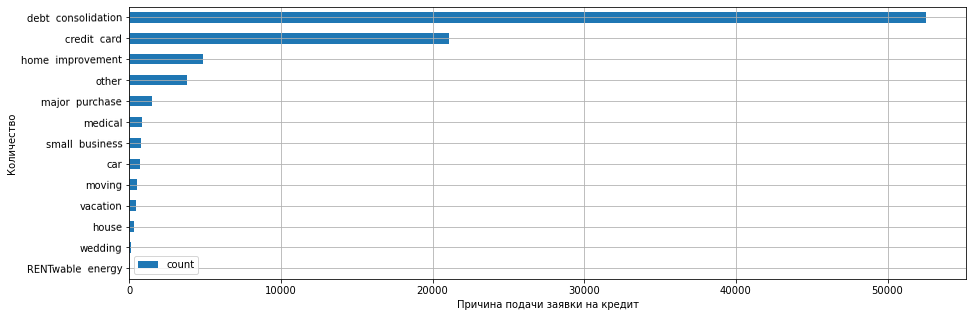

In [130]:
clean_data.Reason.value_counts()\
    .to_frame()\
    .sort_values('count')\
    .plot(
    kind='barh',
    xlabel='Причина подачи заявки на кредит',
    ylabel='Количество',
    figsize=(15,5),
    rot=0.5,
    fontsize=10,
    grid=True
    
)
plt.show()

Заметим, что признак категориальный и номинальный, используем get_dummies

In [131]:
reason_encoder = LabelEncoder()
clean_data.loc[:, 'Reason'] = clean_data.loc[:, ['Reason']]\
    .apply(reason_encoder.fit_transform)

In [132]:
clean_data

,Asst_Reg,GGGrade,Experience,Validation,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Designation,Debt_to_Income,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,File_Status,State,Account_Open,Total_Unpaid_CL,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
95074,421802,5.00,10.00,2.00,633_600.00,3.00,0,0,12862,12.55,42_023.25,0,15.39,88.92,3,607_161.90,0.00,19,0,6,17.00,58_598.00,3.00,31_216.05,3,I,0.00,0
134131,3964312,3.00,7.00,1.00,85_483.20,4.00,0,0,4177,9.00,38_133.00,0,9.94,102.86,0,269_234.06,0.00,30,1,25,15.00,18_924.00,5.00,11_660.49,3,I,0.00,0
92602,4247560,4.00,0.00,1.00,79_200.00,4.00,0,0,36011,24.91,17_100.00,0,22.35,60.37,0,22_476.53,0.00,25,1,9,7.00,15_604.00,5.00,5_637.87,6,I,0.00,0
22591,197179,4.00,0.00,2.00,61_600.00,4.00,0,0,2918,16.58,5_130.00,0,10.36,116.27,1,15_242.09,0.00,22,0,31,9.00,22_410.00,3.00,15_607.17,6,I,0.00,1
125060,4646684,2.00,2.00,1.00,68_053.92,4.00,0,0,16887,40.05,19_665.00,0,13.68,127.28,1,65_433.94,0.00,32,0,16,10.00,36_022.00,5.00,27_472.86,3,I,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120884,4535984,5.00,10.00,0.00,75_680.00,4.00,0,0,10820,19.32,10_260.00,0,8.35,51.08,1,15_100.14,0.00,17,1,19,12.00,32_702.00,3.00,10_012.05,3,I,0.00,0
33259,2624710,3.00,3.00,1.00,90_423.52,4.00,0,0,8465,48.82,27_360.00,0,24.18,129.17,0,102_811.88,0.00,28,1,17,23.00,32_204.00,5.00,24_921.54,3,I,0.00,0
102153,5966919,5.00,10.00,1.00,91_520.00,3.00,0,0,15514,7.80,8_550.00,3,11.03,83.42,1,14_584.11,0.00,16,0,5,8.00,29_050.00,3.00,14_517.90,3,I,0.00,0


## Claim Type - Тип заявки заемщика среди всех типов заявок. (I - Индивидуальный счет, J - Совместный счет)

In [133]:
check_missings('Claim_Type')

Поле Claim_Type не имеет пропусков!


In [134]:
clean_data.Claim_Type.value_counts().to_frame()

,count
Claim_Type,
I,87454
J,46


Аналогичный категориальный номинальный признак

In [135]:
claim_type_encoder = LabelEncoder()
clean_data.loc[:, 'Claim_Type'] = clean_data.loc[:, ['Claim_Type']]\
    .apply(claim_type_encoder.fit_transform)

## Due Fee - Штрафные санкции за задержку выплаты по кредиту

In [136]:
check_missings('Due_Fee')

Поле Due_Fee не имеет пропусков!


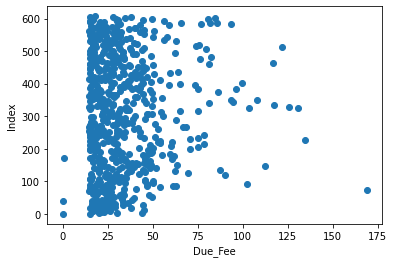

In [137]:
data_counts = clean_data.Due_Fee.value_counts().to_frame().reset_index()
plt.scatter(data_counts['Due_Fee'], data_counts.index)
plt.xlabel('Due_Fee')
plt.ylabel('Index')
plt.show()

По данному признаку что-то сложно сказать конкретно. Большинство = 0, так как штрафов нет, но есть и ненулевые значения

## Loan (default)- Целевая переменная - наличие/отсутствие дефолта (1 - наличие/ 0-отсутствие)

#### Для нас положительным классом является тот, кто не дефолтнится, поэтому введём новую переменную Loan, которая как бы обозначает стоило ли давать человеку кредит. 1- да (то есть дефолт = 0), и 0 - нет, тоесть дефолт = 1

In [138]:
clean_data.loc[:, 'Default'].value_counts().to_frame('Количество значений')

,Количество значений
Default,
0,70988
1,16512


In [140]:
clean_data['Loan'] = np.where(
    clean_data['Default']==0,
    1,
    0
)
clean_data.drop(columns=['Default'], inplace=True)

In [141]:
clean_data.to_csv('data.csv', index=False)